# №9. EarlyStopping & Тестирование модели

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

# plt.style.use('dark_background')

In [4]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

## 1. Тестирование модели

In [5]:
class GenImagesDataset(Dataset):
    def __init__(self, path:str, transform=None):
        self.path = path
        self.transform = transform
        
        self.list_file_names = os.listdir(self.path)
        if 'coords.json' in self.list_file_names:
            self.list_file_names.remove('coords.json')
            
        self.len_dataset = len(self.list_file_names)
        
        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.coords = json.load(f)
        
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index:int):
        file_name = self.list_file_names[index]
        path_img = os.path.join(self.path, file_name)
        
        img = Image.open(path_img)
        coords = np.array(self.coords[file_name], dtype=np.float32)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, coords

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

In [7]:
GEN_IMAGES_FOLDER = os.path.join('data', 'GEN_IMAGES')
dataset = GenImagesDataset(path=GEN_IMAGES_FOLDER, transform=transform)
len(dataset)

100000

array([24., 33.], dtype=float32)

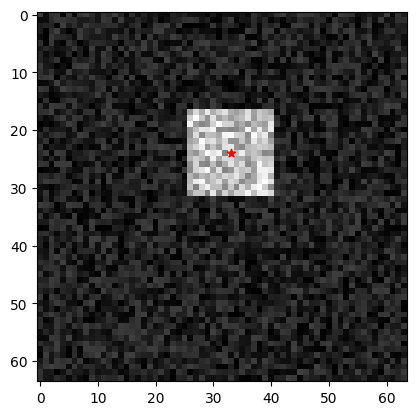

In [8]:
idx = 52
img, coords = dataset[idx]
plt.imshow(img.numpy()[0], cmap='gray')
plt.scatter(coords[1], coords[0], color='r', marker='*')
coords

In [30]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])
len(train_set), len(val_set), len(test_set)

(70000, 10000, 20000)

In [31]:
BATCH_SIZE=32
train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False)

In [32]:
class myRegModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        hidden_size = 64
        self.layer_1 = nn.Linear(input, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, output)
        self.act_func = nn.ReLU()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act_func(x)
        out = self.layer_2(x)
        return out

In [33]:
param_dict = torch.load('models/reg_model_state_dict_10092025_1118.pt', map_location=device)
reg_model = myRegModel(64*64, 2)
reg_model.load_state_dict(param_dict)
reg_model

myRegModel(
  (layer_1): Linear(in_features=4096, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=2, bias=True)
  (act_func): ReLU()
)

In [34]:
x = torch.rand([3, 64*64], dtype=torch.float32).to(device)
out = reg_model(x)
out.shape, out

(torch.Size([3, 2]),
 tensor([[-12.8213, -13.4740],
         [-12.6164, -13.4678],
         [-12.6747, -13.2895]], grad_fn=<AddmmBackward0>))

In [35]:
loss_reg_model = nn.MSELoss()

In [ ]:
all_test_loss = 0
true_answer = 0
test_examples = []

# Тестирование модели
reg_model.eval()
with torch.no_grad():
    count = 0
    for x, targets in tqdm(test_loader, desc="Testing process"):
        if count % 2000 == 0:
            test_examples.append((x[0], targets[0]))
        # Обработка данных

        # (batch_size, 1, 64, 64) --> (batch_size, 64*64)
        x = x.reshape(-1, 64*64).to(device)

        targets = targets.to(device)

        # Прямой проход и расчет ошибки модели
        pred = reg_model(x)
        loss = loss_reg_model(pred, targets)

        all_test_loss += loss.item()

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
            
# Расчет точности    
len_test = len(test_set)
test_mean_loss = all_test_loss / len_test
test_acc = true_answer / len_test
print(f' === TEST RESULTS === ')
print(f"{len_test=}, {all_test_loss=:.4f}, {test_mean_loss=:.4f}, {test_acc=:.4f}")

Testing process: 100%|██████████| 625/625 [01:28<00:00,  7.10it/s]

 === TEST RESULTS === 
len_test=20000, all_test_loss=35.5051, test_mean_loss=0.0018, test_acc=0.9289


In [58]:
print((f"{len(test_examples)=}"))

len(test_examples)=301


Target: tensor([25., 39.])
Pred:   [[24.909119 39.138577]]


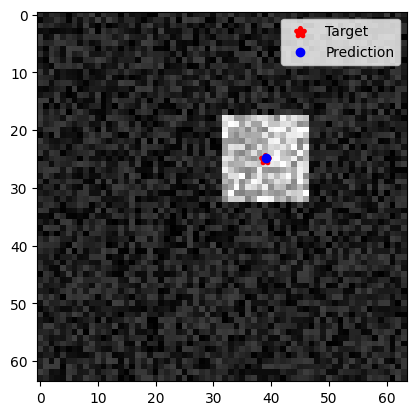

In [85]:
idx = 100
img, coords = test_examples[idx]
pred = reg_model(img.reshape(-1, 64*64)).detach().numpy()

print(f"Target: {coords}")
print(f"Pred:   {pred}")

plt.imshow(img.numpy().reshape((64,64)), cmap='gray')
plt.scatter(coords[1], coords[0], linewidth=3.5, color='r', marker='*')
plt.scatter(pred[0,1], pred[0,0], color='b', marker='o')
plt.legend(['Target', 'Prediction'])

## 2. Остановка обучения

In [86]:
class EarlyStopping:
    def __init__(self, mode='rel', patience=10, threshold=0.001, threshold_mode='rel'):
        self.mode = mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count = 0
        self.best = None
        
    def __call__(self, tracked_parameter):
        current = float(tracked_parameter)
        if self.best is None:
            self.best = current
            return False
        
        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
        else:
            self.count += 1
            
        if self.count >= self.patience:
            self.count = 0
            return True
    
        return False
    
    def changed_better(self, current, best):
        if self.mode == 'min' and self.threshold_mode == 'rel':
            return current < best - best * self.threshold
        
        elif self.mode == 'min' and self.threshold_mode == 'abs':
            return current < best - self.threshold
        
        elif self.mode == 'max' and self.threshold_mode == 'rel':
            return current > best + best * self.threshold
        
        else:  # mode == 'max' and threshold_mode == 'abs':
            return current > best + self.threshold

In [90]:
early_stopping = EarlyStopping()

EPOCHS = 100

for epoch in range(20, EPOCHS):
    # Train
    for _ in range(1):
        # forward
        # backward
        ...
        
    # Validation
        # forward
        
    mean_loss = ...
    
    # Проверка на остановку
    if True or early_stopping(mean_loss):
        print(f" ! Обучение остановлено на {epoch} эпохе.")
        break

 ! Обучение остановлено на 20 эпохе.
